In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from bisect import bisect
torch.cuda.is_available()

True

In [2]:
import pandas as pd
import pyarrow.parquet as pq

# def read_parquet_in_chunks(file_path, chunk_size=100):
#     dfs = []
#     pf = pq.ParquetFile(file_path)
#     for i in range(0, pf.num_row_groups, chunk_size):
#         chunk = pf.read_row_group(i).to_pandas()
#         dfs.append(chunk)
#     return pd.concat(dfs, ignore_index=True)

file1 = 'QCDToGGQQ_IMGjet_RH1all_jet0_run0_n36272.test.snappy.parquet'
file2 = 'QCDToGGQQ_IMGjet_RH1all_jet0_run1_n47540.test.snappy.parquet'
file3 = 'QCDToGGQQ_IMGjet_RH1all_jet0_run2_n55494.test.snappy.parquet'

# df1 = read_parquet_in_chunks(file1)
# df2 = read_parquet_in_chunks(file2)
# df3 = read_parquet_in_chunks(file3)

# # Combine the DataFrames
# df = pd.concat([df1, df2, df3], ignore_index=True)




In [3]:
class ParquetDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.parquet_file = pq.ParquetFile(file_path)
        self.num_row_groups = self.parquet_file.num_row_groups

    def __len__(self):
        return self.num_row_groups

    def __getitem__(self, idx):
        row_group = self.parquet_file.read_row_group(idx).to_pandas()
        image_data = row_group['X_jets'].iloc[0]
        label = row_group['y'].iloc[0]

        # Stack the image data
        image_data = np.stack([np.stack(channel) for channel in image_data], axis=0).astype('float32')
        image_data = torch.tensor(image_data, dtype=torch.float)

        # Explicitly cast label to an integer
        label = int(label)
        label = torch.tensor(label, dtype=torch.long)

        return image_data, label

In [4]:
from torch.utils.data import ConcatDataset

dataset1 = ParquetDataset(file1)
dataset2 = ParquetDataset(file2)
dataset3 = ParquetDataset(file3)


dataset = ConcatDataset([dataset1, dataset2, dataset3])


In [5]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
from e2cnn import gspaces
from e2cnn import nn as enn

r2_act = gspaces.Rot2dOnR2(N=8)  # N: Number of discrete rotations

class EquivariantNetwork(nn.Module):
    def __init__(self, n_classes):
        super(EquivariantNetwork, self).__init__()
        
        self.input_type = enn.FieldType(r2_act, 3 * [r2_act.trivial_repr])
        self.output_type = enn.FieldType(r2_act, 24 * [r2_act.regular_repr])

        self.layer1 = enn.R2Conv(self.input_type, self.output_type, kernel_size=3, stride=1, padding=1)
        self.relu1 = enn.ReLU(self.output_type)

        self.pool1 = enn.R2Conv(self.output_type, self.output_type, kernel_size=3, stride=2, padding=1)

        self.gpool = enn.GroupPooling(self.output_type)

        self.fc1 = nn.Linear(24 * 63 * 63, 64)
        self.fc2 = nn.Linear(64, n_classes)
        
    def forward(self, x):
        x = enn.GeometricTensor(x, self.input_type)
        x = self.relu1(self.layer1(x))
        x = self.pool1(x)
        x = self.gpool(x)
        x = x.tensor.view(x.tensor.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
equivariant_net = EquivariantNetwork(num_classes)
equivariant_net = equivariant_net.to(device)


C:\Users\roder\anaconda3\envs\pt2.0\lib\site-packages\e2cnn\nn\modules\r2_conv\basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen/native/IndexingUtils.h:28.)
  full_mask[mask] = norms.to(torch.uint8)


In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(equivariant_net.parameters(), lr=0.0001)


In [9]:
num_epochs = 10
reg_factor = 0.01

for epoch in range(num_epochs):
    equivariant_net.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = equivariant_net(images)
        loss = criterion(outputs, labels)
        loss += l2_regularization(vgg16, reg_factor)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 0.5989298875342831
Epoch 2/10, Loss: 0.5589273914399586
Epoch 3/10, Loss: 0.5243561527286149
Epoch 4/10, Loss: 0.4817090367589776
Epoch 5/10, Loss: 0.4291343157605607
Epoch 6/10, Loss: 0.3651678797767794
Epoch 7/10, Loss: 0.2865716498831788
Epoch 8/10, Loss: 0.20833704907991507
Epoch 9/10, Loss: 0.13208005041207027
Epoch 10/10, Loss: 0.08407282102115061


In [10]:
# Set the model to evaluation mode
equivariant_net.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0
# Disable gradient computation to save memory and speed up the evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Make predictions
        outputs = equivariant_net(images)
        
        # Get the predicted class (highest value)
        _, predicted = torch.max(outputs.data, 1)
        
        # Update the total number of samples and the number of correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate the accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test dataset: {accuracy * 100:.2f}%')


Accuracy of the model on the test dataset: 65.02%


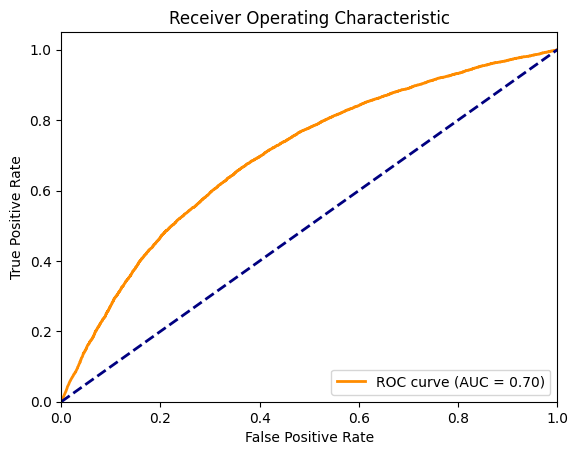

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Set the model to evaluation mode
equivariant_net.eval()

# Initialize lists to store true labels and predicted probabilities
y_true = []
y_probs = []

# Disable gradient computation to save memory and speed up the evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Make predictions
        outputs = equivariant_net(images)
        
        # Get the probability of the positive class (class 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        probs = probs[:, 1].cpu().numpy()
        
        y_probs.extend(probs)
        y_true.extend(labels.cpu().numpy())

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
torch.save(equivariant_net.state_dict(), 'equivariant_net.pt')

Performance comparison:

The CNN model shows higher training loss but higher accuracy on the test set. This indicates that the CNN may be underfitting the training data but generalizes better to the unseen data. On the other hand, the EN model has lower training loss but not as high accuracy on the test set as expected. This suggests that the EN model might be overfitting the training data, learning the noise and irrelevant details in the training dataset, which results in poorer performance on the test set.

Design choices:

The design choice for the CNN model is based on the well-known VGG architecture, which is known for its effectiveness in many computer vision tasks. The fine-tuning approach, rather than training the whole model from scratch, was chosen to leverage the pre-trained weights learned from a larger dataset (e.g., ImageNet). This helps in faster convergence and potentially better performance, especially when the dataset is limited in size.

For the EN model, the choice of using an equivariant neural network is motivated by its ability to naturally handle data with rotational symmetries. The EN model aims to exploit the invariance and equivariance properties of the data to improve the generalization capabilities of the model. However, since EN is a relatively new approach, finding the optimal architecture and hyperparameters can be more challenging compared to conventional CNNs.